In [5]:
import time
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance

In [27]:
def warp_img(img):
    # https://nikolasent.github.io/opencv/2017/05/07/Bird's-Eye-View-Transformation.html
    img_h, img_w = img.shape[0], img.shape[1]

    new_w = 300
    new_h = 400
    src = np.float32(
        [
            [img_w // 3.8, img_h // 2], 
            [img_w // 1.5, img_h // 2], 
            [img_w, img_h], 
            [0, img_h]
        ]
    )
    dst = np.float32(
        [
            [0, 0],
            [new_w, 0],
            [new_w, new_h],
            [0, new_h],
        ]
    )

    # src = np.float32([[0, img_h], [img_w, img_h], [0, img_h // 5], [img_w, img_h // 5]])
    # dst = np.float32([[img_w//3, img_h], [img_w//2, img_h], [0, 0], [img_w, 0]])

    M = cv2.getPerspectiveTransform(src, dst)  # The transformation matrix
    img = cv2.warpPerspective(
        img,
        M,
        (new_w, new_h),
    )  # Image warping
    return img


def apply_gaussian_blur(img, kernel_size=(3, 3)):
    return cv2.GaussianBlur(img, kernel_size, 0)


def apply_canny_edge(img, low_threshold=100, high_threshold=200):
    return cv2.Canny(img, low_threshold, high_threshold)


def apply_dilation(img, kernel_size=(3, 3)):
    return cv2.dilate(img, np.ones(kernel_size, np.uint8))


def apply_erosion(img, kernel_size=(3, 3)):
    # # Apply CLAHE
    # clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    # clahe_image = clahe.apply(img)
    # alpha = 1.5  # Contrast control (adjust as needed)
    # beta = 0  # Brightness control
    # contrast_enhanced = cv2.convertScaleAbs(clahe_image, alpha=alpha, beta=beta)
    # median_filtered_image = cv2.medianBlur(contrast_enhanced, 9)
    # Adjust the kernel size as needed
    kernel = np.ones(kernel_size, np.uint8)
    return cv2.erode(img, kernel, iterations=1)


def detect_hough_lines(img):
    return cv2.HoughLinesP(
        img, rho=1, theta=np.pi / 180, threshold=20, minLineLength=5, maxLineGap=10
    )


def draw_hough_lines(img, lines):
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), 255, 3)
    return img


def detect_correct_mark(img):
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rects = [cv2.minAreaRect(contour) for contour in contours]
    center_bottom = (img.shape[1] // 2, img.shape[0] // 1.5)

    distances = [distance.euclidean(rect[0], center_bottom) for rect in rects]
    btm_cntr_rect_idx = np.argmin(distances)

    return rects, btm_cntr_rect_idx


def draw_rectangle_features(img, rect, throttle, steer, idx):
    width = min(rect[1][1], rect[1][0])
    box = np.intp(cv2.boxPoints(rect))

    top_left = box[np.argmax(box[:, 1])] - np.array([0, 50])
    bottom_left = box[np.argmin(box[:, 1])] - np.array([0, 50])

    cv2.drawContours(img, [box], 0, (255, 0, 0), 2)

    cv2.circle(
        img,
        center=tuple(map(int, rect[0])),
        radius=5,
        color=(255, 255, 255),
        thickness=5,
    )

    cv2.putText(
        img,
        text=str(idx),
        org=tuple(map(int, top_left)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=2,
        color=(255, 255, 255),
        thickness=3,
    )
    return img


def map_values(
    rect: tuple, img: np.ndarray, car_steer: float = 0
) -> tuple[float, float]:
    """
    Map the values for the steer to (-1, 1)
    and the values for the throttle to (0, 1)

    Parameters
    ----------
    rect: tuple
        the rectangle that is used to determine the throttle and steering angle
    img: np.ndarray
        the image that is used to determine the mapping
    Return
    ------
    throttle: float
        the throttle for the car
    steer: float
        the steering angle for the car
    """
    center = rect[0]
    img_center = (img.shape[1] // 2, img.shape[0] // 1.5)

    offset = center[0] - img_center[0]  # offset from the center of the image
    offset = offset / img_center[0]  # normalize the offset

    d1 = rect[1][0]
    d2 = rect[1][1]
    width = min(rect[1][1], rect[1][0])
    height = max(rect[1][1], rect[1][0])
    angle = rect[2]

    # rounding to the nearest 5
    width = int(5 * round(width / 5))
    angle = int(5 * round(angle / 5))

    if angle in (0, 90, -0, -90):
        angle = 0

    elif d1 < d2:
        angle = 90 - angle

    else:
        angle = -angle

    throttle = max(width / (120 + car_steer), 0.4)  # A trial and error value
    steer = angle / (90 + throttle * 100) + (offset)

    return throttle, steer

In [28]:
def show_process_image(img):
    img = warp_img(img)
    img = apply_gaussian_blur(img)
    img_warp = img.copy()
    # img = apply_erosion(img)
    img = apply_canny_edge(img)
    img_canny = img.copy()
    img = apply_dilation(img)
    img_w, img_h = img.shape[1], img.shape[0]
    
    lines = detect_hough_lines(img)
    if lines is None:
        return img, np.zeros((img_h, img_w), dtype=np.uint8)
    
    img_hou = np.zeros((img_h, img_w), dtype=np.uint8)
    draw_hough_lines(img_hou, lines)

    rects, bottom_center_rect_idx = detect_correct_mark(img_hou)

    throttle, steer = map_values(rects[bottom_center_rect_idx], img_hou)
    # return throttle, steer

    img_hou = cv2.cvtColor(img_hou, cv2.COLOR_GRAY2RGB)

    center_bottom = (img_hou.shape[1]//2, img_hou.shape[0]//1.5)
    cv2.circle(img_hou,
                center=tuple(map(int, center_bottom)),
                radius=50,
                color=(0, 0, 255),
                thickness=10)
    for i, rect in enumerate(rects):
        img_hou = draw_rectangle_features(img_hou, rect, throttle, steer, idx=i)
        if i == bottom_center_rect_idx:
            cv2.putText(img_hou,
                        text=f"SELECTED {i}",
                        org=(0, 50),
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale=1,
                        color=(0, 255, 255),
                        thickness=3)
    return img_canny, img_hou


def process_image(img):
    img = warp_img(img)
    img = apply_gaussian_blur(img)
    img = apply_canny_edge(img)
    img = apply_dilation(img)
    img_w, img_h = img.shape[1], img.shape[0]
    
    lines = detect_hough_lines(img)
    if lines is None:
        return -1, 0
    
    img_hou = np.zeros((img_h, img_w), dtype=np.uint8)
    draw_hough_lines(img_hou, lines)

    rects, bottom_center_rect_idx = detect_correct_mark(img_hou)

    throttle, steer = map_values(rects[bottom_center_rect_idx], img_hou)
    return steer, throttle

In [29]:
def show_imgs(imgs, titles):
    rows = int(np.ceil(len(imgs) / 3 ))
    cols = 3
    figsize = (cols * 5, rows * 6)
    _, axs = plt.subplots(rows, cols, figsize=figsize)
    for img, title, ax in zip(imgs, titles, axs.flatten()):
        ax.imshow(img, cmap="gray")
        ax.set_title(title)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

### Expermintation results
1. Angle 0, Speed 0 detection is working decently
2. Angle 0, Speed 5 detection is not workin correctly if the first segment is cropped at the bottom of the image.
3. Angle 0, Speed 15 detection is working correctly in terms of the anlge, but the speed is not detected correctly and it depends on the distance of the segment from the bottom of the image. Some form of normalization is needed.
4. Angle 0, Speed 30 detection is same as above.

5. Angle 10, Speed 5 detection seems to working for the most part. Some rounding to values needs to be done.
6. Angle 10, Speed 15 detection is similar to above. There migh be an overlap with the angle 20.

7. Angle 20, Speed 5 detection is not workin correctly if the first segment is cropped at the bottom of the image.
8. Angle 20, Speed 15 detection is 

<br><br>

##### Notes:
- Using a smaller size for the images would greatly improve the performance.

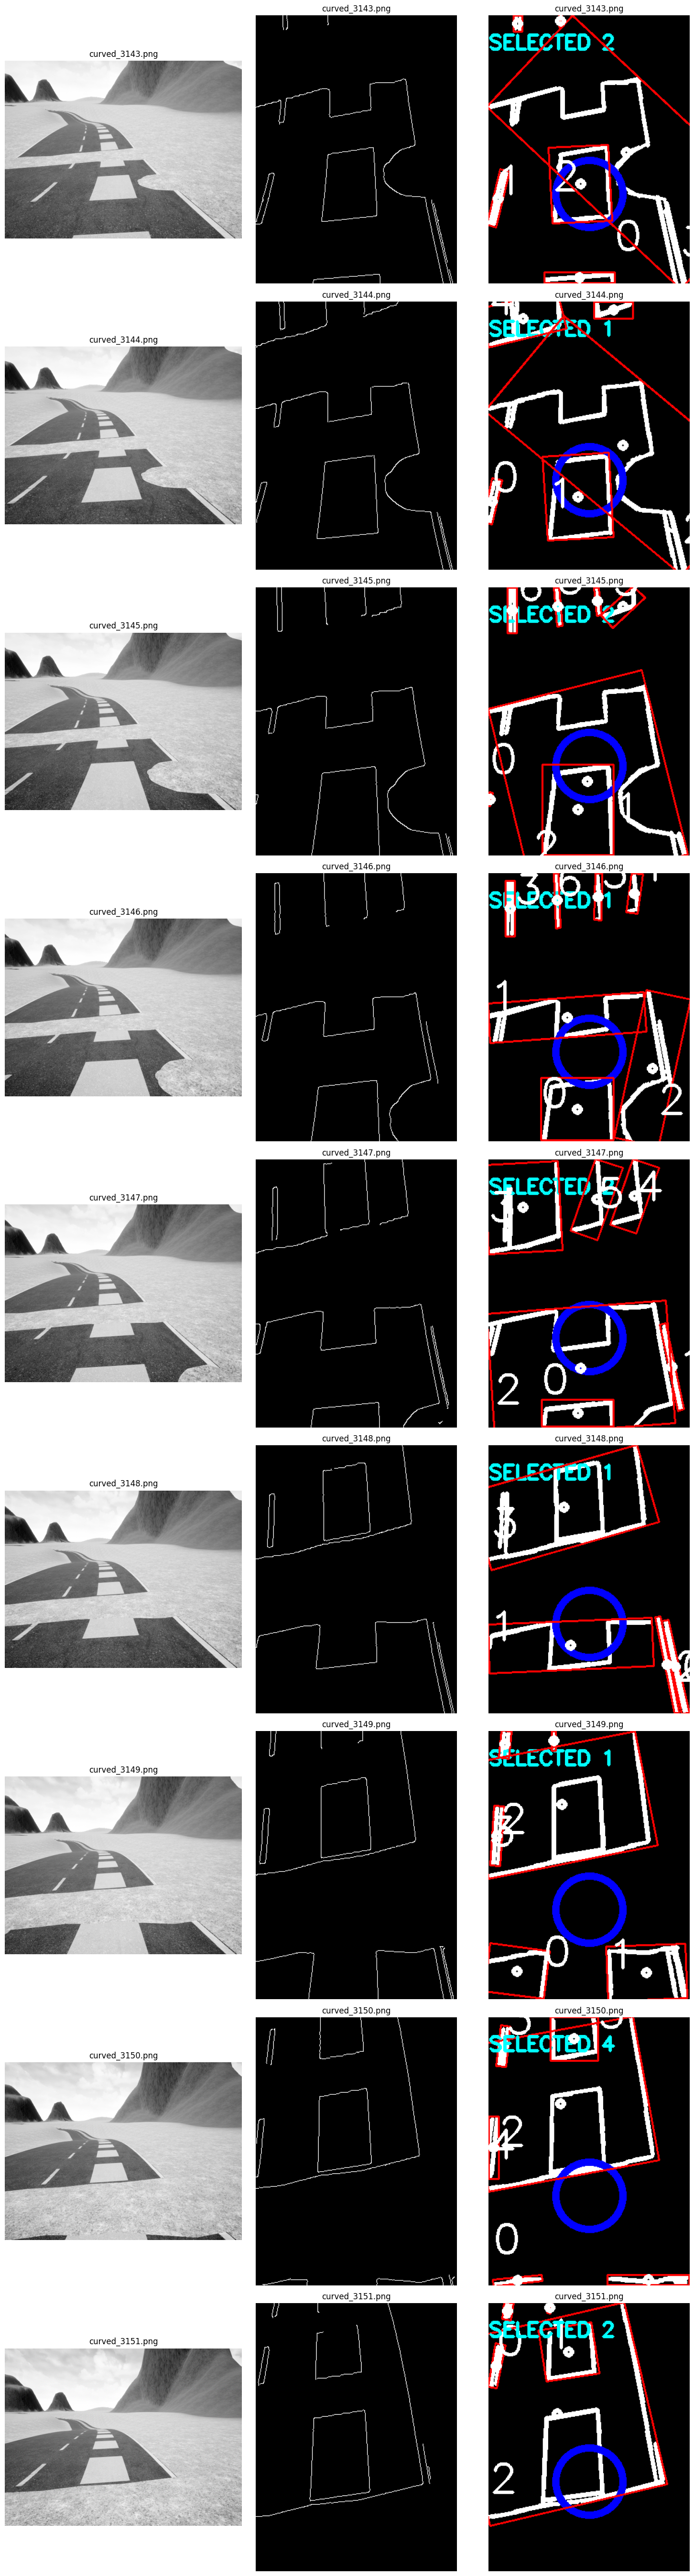

In [30]:
folder = "imgs_edge_cases/new_env"
images = []
titles = []

for img_name in os.listdir(folder):
    img = cv2.imread(os.path.join(folder, img_name), cv2.IMREAD_GRAYSCALE)
    img_warp, img_hou = show_process_image(img)
    images.extend([img, img_warp, img_hou])
    titles.extend([img_name, img_name, img_name])

show_imgs(images, titles)

In [31]:
# %%timeit
# start_time = time.perf_counter()

folder = "imgs_edge_cases/new_env/"
images = os.listdir(folder)

img = cv2.imread(os.path.join(folder, images[0]), cv2.IMREAD_GRAYSCALE)
steer, throttle = process_image(img)
print(f"Steer: {steer:.2f}, \tThrottle: {throttle:.2f}")

# end_time = time.perf_counter()
# print(f"Time taken: {end_time - start_time:.2f} seconds")

Steer: -0.24, 	Throttle: 0.71


In [31]:
cap = cv2.VideoCapture('imgs_edge_cases/output.mp4')

while cap.isOpened():
    ret, frame = cap.read()
    if cv2.waitKey(1) & 0xFF == ord('q') or ret == False:
        break
    frame_warp, frame_hou = show_process_image(frame)
    cv2.imshow('Frame', frame)
    cv2.imshow('Frame Warp', frame_warp)
    cv2.imshow('Frame Hough', frame_hou)

cap.release()
cv2.destroyAllWindows()